In [2]:
!pip install icrawler

In [3]:
# 必要なモジュールをインポート
from icrawler.builtin import BingImageCrawler
import numpy as np
from PIL import Image
import pandas as pd

In [4]:
df = pd.read_csv('/content/pokemon.csv')
df.head()

,pokemon_id,name,hit_points,attack,defense,special_attack,special_defense,speed
0,1,フシギダネ,45,49,49,65,65,45
1,2,フシギソウ,60,62,63,80,80,60
2,3,フシギバナ,80,82,83,100,100,80
3,4,ヒトカゲ,39,52,43,60,50,65
4,5,リザード,58,64,58,80,65,80


In [5]:
# キーワードを指定
keywords = df['name'].tolist()

In [6]:
# ルートディレクトリを定義
root_dir = './pokemon/'

In [ ]:
# スクレイピング
for keyword in keywords:
    target_dir = root_dir + keyword
    crawler = BingImageCrawler(storage = {'root_dir' : target_dir})
   # 枚数を指定
    max_num = 3
    crawler.crawl(keyword = keyword + ' ポケモン', max_num = max_num)

In [8]:
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

# 1枚あたり20枚の画像を水増し
N_img = 20

for keyword in keywords:
    # 入力画像の保存先パス
    input_path = "/content/pokemon/" + keyword
    files = glob.glob(input_path + '/*.jpg')
    
    # 出力画像の保存先パス
    output_path = "/content/pokemon/" + keyword
    for i, file in enumerate(files):
    
        img = load_img(file)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
    
        # ImageDataGeneratorの生成
        datagen = ImageDataGenerator(
            zca_epsilon=1e-06,   # 白色化のイプシロン
            rotation_range=10.0, # ランダムに回転させる範囲
            width_shift_range=0.0, # ランダムに幅をシフトさせる範囲
            height_shift_range=0.0, # ランダムに高さをシフトさせる範囲
            brightness_range=None, # ランダムに明るさを変化させる範囲
            zoom_range=0.0,        # ランダムにズームさせる範囲
            horizontal_flip=True, # ランダムに水平方向に反転させる
            vertical_flip=True, # ランダムに垂直方向に反転させる
        )
    
        # 1枚あたり20枚の画像を水増し生成
        dg = datagen.flow(x, batch_size=1, save_to_dir=output_path, save_prefix='img', save_format='jpg')
        for i in range(N_img):
            batch = dg.next()

In [9]:
from torchvision import transforms, datasets

In [12]:
# 前処理
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# ラベル付け
dataset = datasets.ImageFolder('/content/pokemon', transform)

In [13]:
dataset

Dataset ImageFolder
    Number of datapoints: 10641
    Root location: /content/pokemon
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [14]:
len(dataset)

10641

In [ ]:
!pip install -q pytorch_lightning
!pip install -q torchmetrics

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision import datasets
import pytorch_lightning as pl
import torchmetrics
from torchmetrics.functional import accuracy
import torchsummary
from torchsummary import summary
from pytorch_lightning.loggers import CSVLogger

In [39]:
# 1サンプル目
x, t = dataset[1300]

In [40]:
# 目標値
t

20

2022-05-02 09:59:37,358 - WARNING - matplotlib.image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


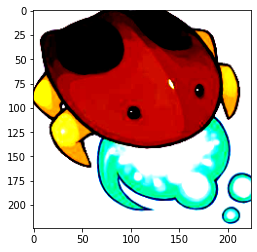

In [41]:
# 可視化
plt.imshow(x.permute(1, 2, 0));

In [20]:
# train と val に分割
pl.seed_everything(0)
n_train, n_val = 6000, 4641
train, val = torch.utils.data.random_split(dataset, [n_train, n_val])

# バッチサイズの定義
batch_size = 256

# Data Loader を定義
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)

2022-05-02 07:15:16,547 - INFO - pytorch_lightning.utilities.seed - Global seed set to 0


In [21]:
# 学習済みネットワークの利用
from torchvision.models import resnet18

In [22]:
# ResNet を特徴抽出機として使用
feature = resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [23]:
# 訓練済みモデルを用いた推論
h = feature(x.unsqueeze(0))
h.shape

torch.Size([1, 1000])

In [24]:
class Net(pl.LightningModule):

    def __init__(self):
        super().__init__()

        self.feature = resnet18(pretrained=True)
        self.fc = nn.Linear(1000, 151)


    def forward(self, x):
        h = self.feature(x)
        h = self.fc(h)
        return h


    def training_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log('train_acc', accuracy(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss


    def validation_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', accuracy(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss


    def test_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_acc', accuracy(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss


    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        return optimizer

In [ ]:
# 学習の実行
pl.seed_everything(0)
net = Net()
logger = CSVLogger(save_dir='logs', name='my_exp')
trainer = pl.Trainer(max_epochs=5, gpus=0, deterministic=False, logger=logger)
trainer.fit(net, train_loader, val_loader)

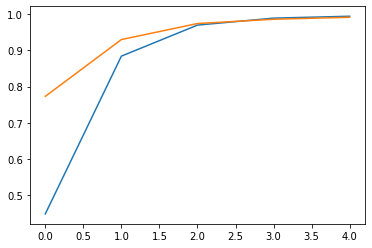

In [100]:
log = pd.read_csv('/content/logs/my_exp/version_3/metrics.csv')
log[['train_acc', 'epoch']].dropna(how='any', axis=0).reset_index()['train_acc'].plot();
log[['val_acc', 'epoch']].dropna(how='any', axis=0).reset_index()['val_acc'].plot();

In [26]:
# 学習済みモデルの保存
torch.save(net.state_dict(), 'image.pt')

In [27]:
from google.colab import files
files.download('/content/image.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ネットワークの準備
net = Net()

# 重みの読み込み
net.load_state_dict(torch.load('image.pt'))
net.eval()

In [48]:
# 1サンプル目
x, t = dataset[1000]

# 予測値の算出
y = net(x.unsqueeze(0))

# 確率に変換
y = F.softmax(y)

# # 予測ラベル
y = torch.argmax(y)
print(y, t)

tensor(15) 15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
